# Assignment 1 (part II):  Automatic Panorama Mosaicing

In [114]:
import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matched_features, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

### The cell below demonstrates feature detection (e.g. corners) and matching (e.g. BRIEF descriptor) 

the number of matches is 56


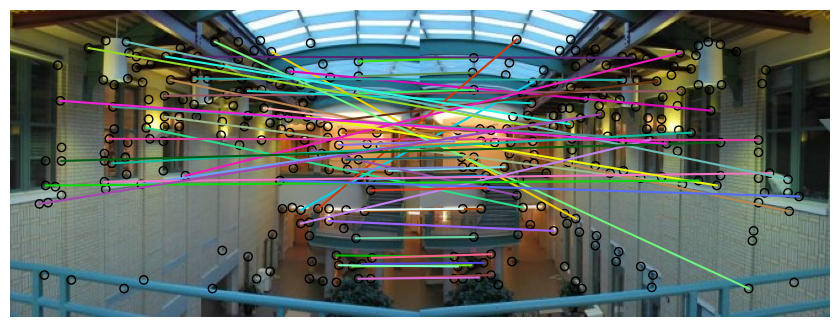

In [115]:
imL = image.imread("images/CMU_left.jpg")
imR = image.imread("images/CMU_right.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.0005, min_distance=5)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.0005, min_distance=5)

extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matched_features(imL, imR, keypoints0=keypointsL, keypoints1=keypointsR, matches=matchesLR, ax=axA)
axA.axis('off')

plt.show()

## Problem 1
### Rederive your formula in Problem 4a from Part I of the assignment for the following modification. Assume there are $N=53$ matches $(p,p')$ as in figure 1 above. $N_i=21$ of these matches are inliers for a homography, while the rest of the matches are $N_o=32$ outliers. To estimate a homography you need a sample with $K=4$ matches. What is the least number of times one should randomly sample a subset of $K$ matches to get probability  $p≥0.95$  that at least one of these samples has all of its $K$ matches from inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution: For the general formula, assume we are given $N$ points in with $N_i$ inliers and $N_o = N - N_i$ outliers. 
The probability that one samples $k$ random sets of 4 points and at least one of the sampled sets are all inliers is equal to $\text{Pr}(\text{at least one the k samples are all inliers}) = 1- \text{Pr}(\text{none of the k samples are all inliers})$.

We assume that the pairs are sampled independently and with replacement. We also assume that we are sampling four distinct points for each set. The probability of a single sample containing four inliers is 
$$\text{Pr}(\text{four inliers}) = \frac{N_i(N_i - 1)(N_i - 2)(N_i - 3)}{N(N-1)(N-2)(N-3)}$$
So the probability of not sampling four inliers is 

$$\text{Pr}(\text{not four inliers}) = 1 - \text{Pr}(\text{four inliers}) = 1- \frac{N_i(N_i - 1)(N_i - 2)(N_i - 3)}{N(N-1)(N-2)(N-3)}$$

Thus, the probability of not sampling four inliers k times is:
$$\text{Pr}(\text{none of the k samples are all inliers}) = \Big(\text{Pr}(\text{not four inliers}) \Big)^k = \Big(1- \frac{N_i(N_i - 1)(N_i - 2)(N_i - 3)}{N(N-1)(N-2)(N-3)}\Big)^k$$

Finally, the probability of one of the $k$ samples being four inliers is
$$\text{Pr}(\text{at least one the k samples are all inliers}) = 1- \text{Pr}(\text{none of the k samples are all inliers}) = 1 - \Big(1- \frac{N_i(N_i - 1)(N_i - 2)(N_i - 3)}{N(N-1)(N-2)(N-3)}\Big)^k$$ 

To determine the minimal $k$ we lower bound the expression:

$$\begin{align*}\text{Pr}(\text{at least one the k samples are all inliers}) \ge& p \\ 1 - \Big(1- \frac{N_i(N_i - 1)(N_i - 2)(N_i - 3)}{N(N-1)(N-2)(N-3)} \Big)^k \ge& p \\ 1-p \ge& \Big(1- \frac{N_i(N_i - 1)(N_i - 2)(N_i - 3)}{N(N-1)(N-2)(N-3)} \Big)^k \\ \log(1-p) \le& k \log\Big(1- \frac{N_i(N_i - 1)(N_i - 2)(N_i - 3)}{N(N-1)(N-2)(N-3)} \Big) \\ \frac{\log(1-p)}{\log\Big(1- \frac{N_i(N_i - 1)(N_i - 2)(N_i - 3)}{N(N-1)(N-2)(N-3)} \Big)} \le& k \\\end{align*}$$

To compute a numerical answer for our given numbers, we substitute them into the formula:
$$\begin{align*} \frac{\log(1-0.95)}{\log\Big(1- \frac{(21)(20)(19)(18)}{53(52)(51)(50)}\Big)} \le& k \\ 145.06762 \le& k \end{align*}$$

So the smallest number of samples we need to make to have at least a $0.95$ probability of getting a sample of four inlier points is $k=146$.


## Problem 2: (RANSAC for Homographies)
### Write code below using RANSAC to estimate Homography from matched pairs of points above. This cell should display new figure 2 similar to figure 1 above, but it should show only inlier pairs for the detected homography. HINT: you can use $ProjectiveTransform$  from library $skimage$ declared at the top of the notebok.

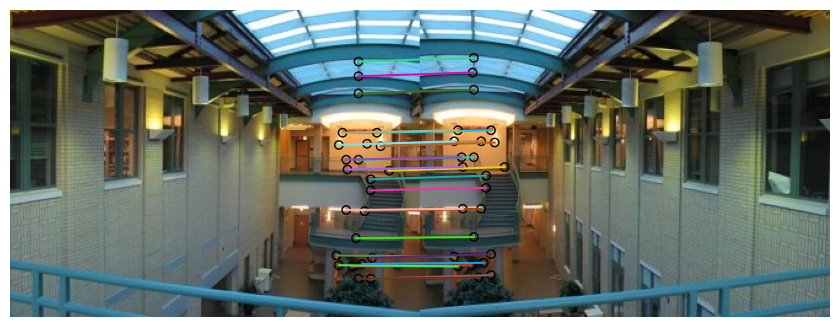

In [123]:
# store array of pairs of matched points of left and right iage
model_robust, inliers = ransac((keypointsL[matchesLR[:, 0]][:, ::-1], keypointsR[matchesLR[:, 1]][:, ::-1]), ProjectiveTransform, min_samples=4, residual_threshold=15, max_trials=146)

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()

num_matches = np.sum(inliers)
plot_matched_features(imL, imR, keypoints0=keypointsL[matchesLR[inliers, 0]], keypoints1=keypointsR[matchesLR[inliers, 1]], matches=np.column_stack((np.arange(num_matches), np.arange(num_matches))), ax=axA)
axA.axis('off')

plt.show() 

## Problem 3 (reprojecting onto common PP)
### Use common PP corresponding to the plane of the left image. Your panorama mosaic should be built inside a "reference frame" (think about it as an empty canvas of certain size) inside this common PP. The reference frame should be big enough to contain the left image and the part of the view covered by the right image after reprojecting onto common PP. Create a new figure 3 including the following three images (spread them vertically). First, show your reference frame only with the left image inside. Second, show the reference frame containing only a reprojected right image (warp it using a homography computed in Problem 1). Third, for comparison, show the reference frame containing only the right image reprojected using a (bad) homography estimated from all matches (including outliers, as in figure 1).
#### HINT1: use function $warp$ from library $skimage$ declared at the top of the notebook. 
#### HINT2: function $warp$ needs "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities

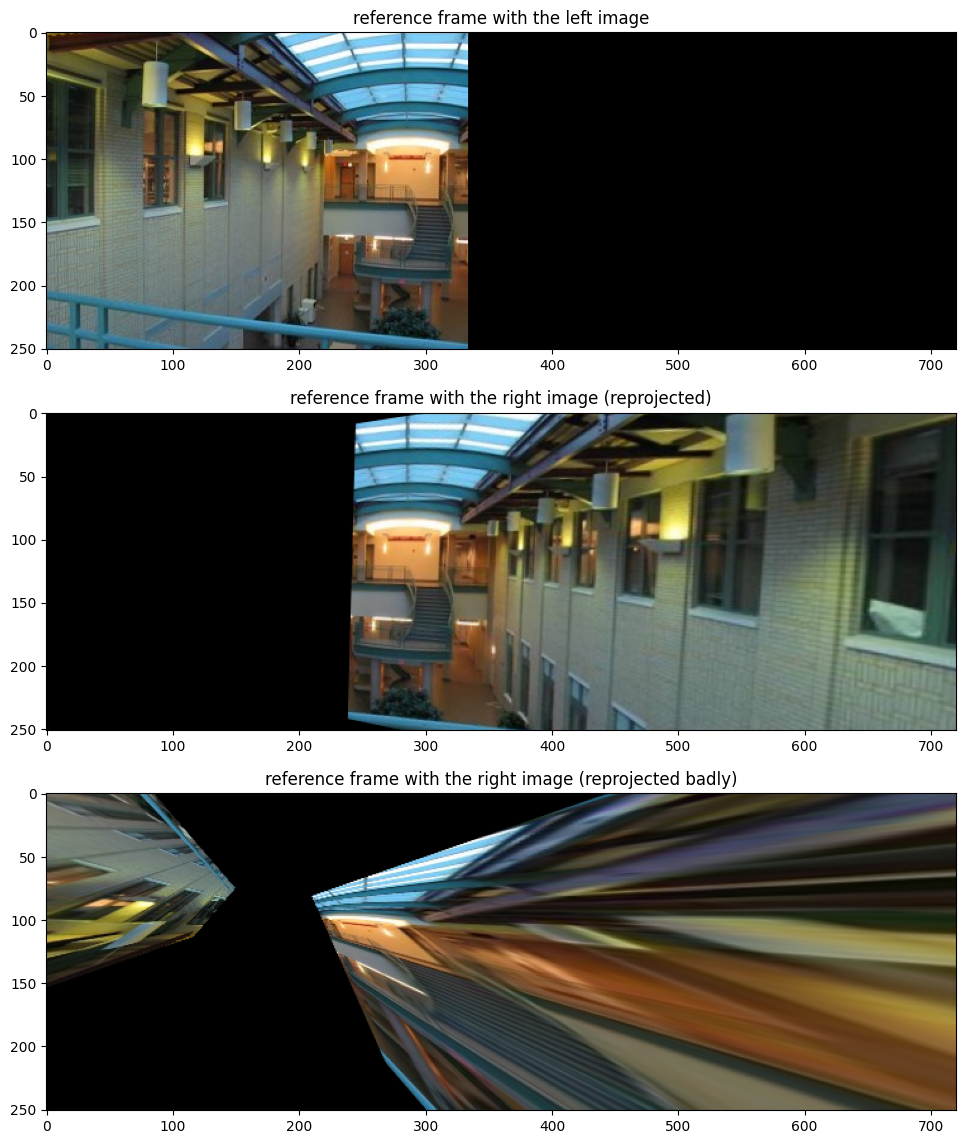

In [124]:
# perform identity projection on left image
identityL = ProjectiveTransform()
identity_imL = warp(imL, inverse_map=identityL.inverse, output_shape=(251, 720)) 

fig = plt.figure(3,figsize = (12, 14))
plt.subplot(311)
plt.imshow(identity_imL)
plt.title("reference frame with the left image")

# use ransac projection from above
plt.subplot(312)
ransac_imR = warp(imR, inverse_map=model_robust, output_shape=(251, 720))
plt.imshow(ransac_imR)
plt.title("reference frame with the right image (reprojected)")

# perform projection using all keypoints
plt.subplot(313)
model_bad = ProjectiveTransform()
model_bad.estimate(keypointsL[matchesLR[:,0]][:,::-1], keypointsR[matchesLR[:,1]][:,::-1])
bad_imR = warp(imR, inverse_map=model_bad, output_shape=(251, 720))
plt.imshow(bad_imR)
plt.title("reference frame with the right image (reprojected badly)")

plt.show()

## Problem 4 (blending)

### (part a) Write code for a function below computing distance transform for the boundary of a given image. It returns a numpy array of the same size as the image with distances from each pixel to the closest point on the boundary of the image (float values). 
   

In [125]:
def boundaryDT(image):
        m, n, _ = image.shape
        
        y_indices, x_indices = np.ogrid[:m, :n]
        
        # compute distance from top, bottom, left, right boundary
        top = y_indices
        bottom = m - 1 - y_indices
        left = x_indices
        right = n - 1 - x_indices
        # return minimum distance
        return np.minimum(np.minimum(top, bottom), np.minimum(left, right))

### (part b) Use function from part (a) to compute a distance transform for both images. Create a new figure 4 showing the following two images. First, show reference frame containing only the left image's boundaryDT instead of the left image. Second, show reference frame containing only the right image's boundaryDT reprojected instead of the right image. 

Text(0.5, 1.0, 'Right image DT in Ref. frame (RdtRef)')

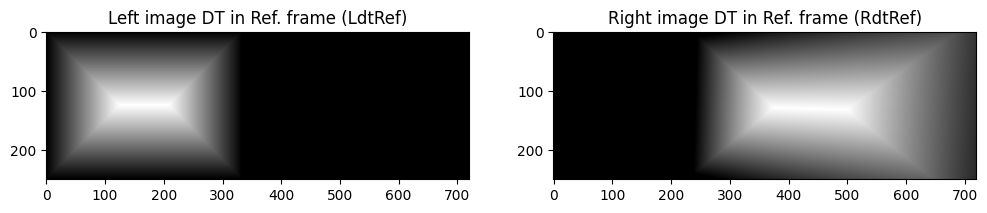

In [ ]:
fig = plt.figure(4,figsize = (12, 3))
plt.subplot(121)
boundary_imL = warp(boundaryDT(imL), inverse_map=identityL, output_shape=(251, 720))
plt.imshow(boundary_imL)
plt.title("Left image DT in Ref. frame (LdtRef)")

# apply same projection from above on boundary image
plt.subplot(122)
boundary_imR = warp(boundaryDT(imR), inverse_map=model_robust, output_shape=(251, 720))
plt.imshow(boundary_imR)
plt.title("Right image DT in Ref. frame (RdtRef)")

### (part c) Use boundary distance transforms to blend left and right images (reprojected) into the reference frame. Create a new figure 5 showing the following three images. The first and second images should be smooth $alpha$'s suitable for blending the left and right images (e.g. based on distance transforms as discussed in class). The third image should be your panorama: left and (reprojected) right images blended inside the reference frame. Your panorama should also show (reprojected) features - homography inliers - from both left and right images. Use different colors/shapes to distinct features from the left and the right images.

C:\Users\dingj\AppData\Local\Temp\ipykernel_20860\1821409188.py:9: RuntimeWarning: invalid value encountered in divide
  alpha1 = alpha_imL / (alpha_imL + alpha_imR)
C:\Users\dingj\AppData\Local\Temp\ipykernel_20860\1821409188.py:14: RuntimeWarning: invalid value encountered in divide
  alpha2 = alpha_imR / (alpha_imL + alpha_imR)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000000000002].


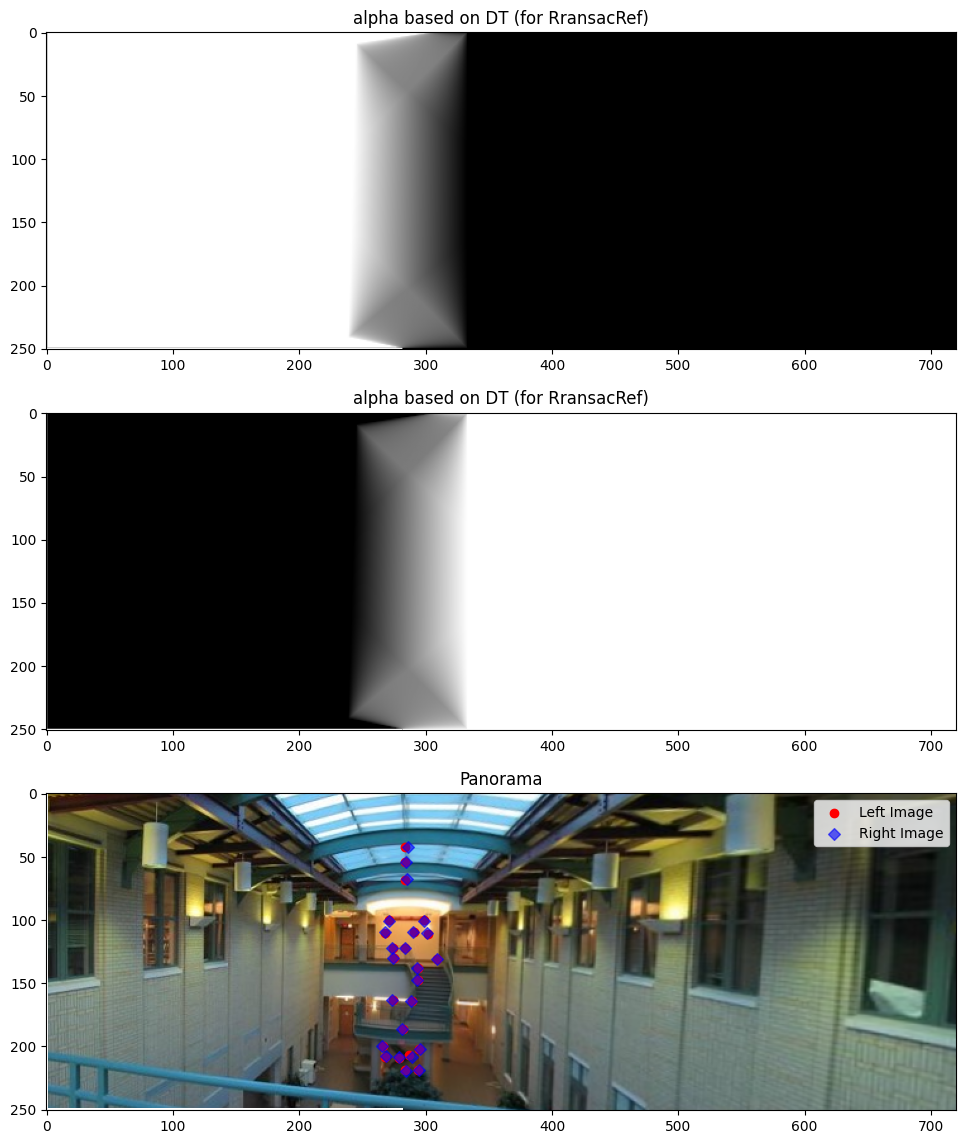

In [149]:
fig = plt.figure(5,figsize = (12, 14))
plt.subplot(311)

alpha_imL = boundary_imL[:, :, np.newaxis]
alpha_imL /= np.max(alpha_imL)
alpha_imR = boundary_imR[:, :, np.newaxis]
alpha_imR /= np.max(alpha_imR)

alpha1 = alpha_imL / (alpha_imL + alpha_imR)
plt.imshow(alpha1, cmap="gray")
plt.title("alpha based on DT (for RransacRef)")

plt.subplot(312)
alpha2 = alpha_imR / (alpha_imL + alpha_imR)
plt.imshow(alpha2, cmap="gray")
plt.title("alpha based on DT (for RransacRef)")

plt.subplot(313)
panorama = alpha1 * identity_imL  + alpha2 * ransac_imR
original_keypointsL = keypointsL[matchesLR[inliers, 0]][:, ::-1]
projected_keypointsR = model_robust.inverse(keypointsR[matchesLR[inliers, 1]][:, ::-1])
plt.imshow(panorama)
plt.scatter(original_keypointsL[:, 0], original_keypointsL[:, 1], color='r', alpha = 1, marker='o', label="Left Image")
plt.scatter(projected_keypointsR[:, 0], projected_keypointsR[:, 1], color='b', alpha = 0.6, marker='D', label="Right Image")
plt.legend()
plt.title("Panorama")

plt.show()